# Model: Hand Detection using transfer learning (MediaPipe Alternatives)

## Model 1: From VGG16
## Model 2: From MobileNet
pre-trained on imagenet

_Bastien Leduc - A20520860_\
_Paul Legout - A20522029_

In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import models, layers

import preprocessing
from resources import *

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, recall_score, precision_score
from keras.utils import img_to_array, load_img, plot_model

import cv2

from keras.applications.vgg16 import VGG16

import keras.backend as K
from keras.applications.mobilenet import MobileNet

import time
from random import randint
from colorama import Fore

In [51]:
import importlib

import resources
importlib.reload(preprocessing)
importlib.reload(resources)
from resources import *

Some useful paths

In [3]:
DIR_DATA = "../../data"
DIR_ANNOTATIONS = DIR_DATA + "/annotations"
DIR_IMAGES = DIR_DATA + "/.data"
# DIR_IMAGES = DIR_DATA + "/sampled"

### Load data

In [4]:
# Load data
x, y = preprocessing.load_data_hand_detection(DIR_ANNOTATIONS, DIR_IMAGES)

In [4]:
x.shape

(32371,)

In [11]:
y[0]

[array([0.6295725 , 0.39665797, 0.20516206, 0.16012795], dtype=float32),
 array([[0.7044328 , 0.54272074],
        [0.75471276, 0.5230726 ],
        [0.795089  , 0.4831976 ],
        [0.80693096, 0.44751522],
        [0.79924047, 0.4177101 ],
        [0.75787   , 0.44241995],
        [0.78193414, 0.43806636],
        [0.7784305 , 0.4700569 ],
        [0.76916426, 0.49553484],
        [0.7232472 , 0.44144732],
        [0.7489952 , 0.44366515],
        [0.746927  , 0.4836276 ],
        [0.74085027, 0.5119845 ],
        [0.6881746 , 0.44689488],
        [0.71415836, 0.44915146],
        [0.7185041 , 0.4892539 ],
        [0.7169018 , 0.51772135],
        [0.6518133 , 0.45671645],
        [0.67860967, 0.45362037],
        [0.6900775 , 0.48167935],
        [0.69272244, 0.5023207 ]], dtype=float32)]

In [5]:
# Total number of elements
dataset_size = len(x)
dataset_size

32371

In [23]:
x[0]

'../../data/.data/ok/000c55f3-a2c5-4dc0-9155-135bd391ddd1.jpg'

### Prepare and split data

70% training, 10% validation and 20% test

In [6]:
BATCH_SIZE = 32
IMG_WIDTH = 1920 
IMG_HEIGHT = 1080

In [7]:
train_perc = 0.7
test_perc = 0.2
val_perc = 0.1


x, y = shuffle(x, y)

In [8]:
def get_gen(lower_boundary: int, higher_boundary: int, x: np.array, y: np.array, square_img=False, with_labels=False):
	for i in range(lower_boundary, higher_boundary):
		try:
			img = img_to_array(load_img(x[i])) / 255.0
		
			# resize images to same size each

			width = img.shape[0]
			height = img.shape[1]

			if width > IMG_WIDTH or height > IMG_HEIGHT:
				img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
				# Downsample for training (my computer can't handle training using Full HD resolution images)
				img = cv2.pyrDown(img)
				img = cv2.pyrDown(img)
				
			if width > IMG_WIDTH // 2 or height > IMG_HEIGHT // 2:
				img = cv2.resize(img, (IMG_HEIGHT // 2, IMG_WIDTH // 2))
				img = cv2.pyrDown(img)
			
			else: img = cv2.resize(img, (IMG_HEIGHT // 4, IMG_WIDTH // 4))

			# MobileNet pre-trained requires square img, low quality...
			if square_img: img = cv2.resize(img, (224, 224))
			
			yield img, (y[i][0], y[i][1])
		except Exception: continue

def get_labels(lower_boundary: int, higher_boundary: int, x: np.array, y: np.array)
		

auto = tf.data.AUTOTUNE
def get_dataset(lower_perc: float, higher_perc: float, x: np.array, y: np.array, batch_size: int, dataset_size: int, repeat=True, square_img=False, with_labels=False):
	dataset = tf.data.Dataset.from_generator(
				lambda: map(tuple, get_gen(int(lower_perc * dataset_size), int(higher_perc * dataset_size), x, y, square_img, with_labels)), 
				output_types=(tf.float32, len(y[0]) * (tf.float32, ))
			).cache().prefetch(auto)
	
	if batch_size != 0: dataset = dataset.batch(batch_size)
	if repeat: dataset = dataset.repeat()
	return dataset


In [ ]:
train_gen = get_dataset(0, train_perc, x, y, BATCH_SIZE, dataset_size)

test_gen = get_dataset(train_perc, train_perc + test_perc, x, y, BATCH_SIZE, dataset_size, repeat=False)

val_gen = get_dataset(1 - val_perc, 1, x, y, BATCH_SIZE, dataset_size)

In [ ]:
next(iter(train_gen))[1][0].shape

### Model 1: From VGG16

In [9]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH // 4, IMG_HEIGHT // 4, 3))

In [10]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 270, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 270, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 270, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 135, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 135, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 135, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 120, 67, 128)      0     

In [87]:
def create_model(base_model: models.Model, output_dim_bboxes: int, output_shape_landmarks: tuple):
	
	#################### Feature extraction ####################

	input_tensor = base_model.input

	x = base_model(input_tensor)

	# (None, 7, 7, 1024)

	x = layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), activation="relu")(x)

	# (None, 5, 5, 512)
	
	#################### Boxes ####################

	x_bboxes = layers.Conv1D(512, kernel_size=x.shape[2], strides=1, name="bboxes_branch")(x)
	x_bboxes = layers.BatchNormalization(name="bboxes_branch_norm")(x_bboxes)
	x_bboxes = layers.Activation("relu")(x_bboxes)
	x_bboxes = layers.Reshape(target_shape=(-1, 512))(x_bboxes)

	# (None, 5, 512)
	x_bboxes = layers.Flatten()(x_bboxes)
	
	x_bboxes = layers.Dense(128, name="bboxes_branch_2")(x_bboxes)
	x_bboxes = layers.BatchNormalization(name="bboxes_branch_2_norm")(x_bboxes)
	x_bboxes = layers.Activation("relu")(x_bboxes)
	
	x_bboxes = layers.Dense(64, name="bboxes_branch_3")(x_bboxes)
	x_bboxes = layers.BatchNormalization(name="bboxes_branch_3_norm")(x_bboxes)
	x_bboxes_out = layers.Activation("relu")(x_bboxes)

	x_bboxes = layers.Dense(output_dim_bboxes, activation="sigmoid", name="bboxes")(x_bboxes_out)

	# Shape (None, 4)
	
	#################### Landmarks ####################
	
	x_landmarks = layers.Conv1D(512, kernel_size=x.shape[2], strides=1)(x)
	x_landmarks = layers.BatchNormalization()(x_landmarks)
	x_landmarks = layers.Activation("relu")(x_landmarks)
	x_landmarks = layers.Reshape(target_shape=(-1, 512))(x_landmarks)

	# (None, 5, 512)
	x_landmarks = layers.Conv1D(256, kernel_size=3, strides=1)(x_landmarks)
	x_landmarks = layers.BatchNormalization()(x_landmarks)
	x_landmarks = layers.Activation("relu")(x_landmarks)

	# (None, 3, 256)
	x_landmarks = layers.Flatten()(x_landmarks)

	x_landmarks = layers.Concatenate(axis=1)([x_landmarks, x_bboxes_out])

	x_landmarks = layers.Dense(128)(x_landmarks)
	x_landmarks = layers.BatchNormalization()(x_landmarks)
	x_landmarks = layers.Activation("relu")(x_landmarks)
	x_landmarks = layers.Dense(output_shape_landmarks[0] * output_shape_landmarks[1], activation="sigmoid")(x_landmarks)

	# (None, 42)
	x_landmarks = layers.Reshape(target_shape=(-1, output_shape_landmarks[1]), name="landmarks")(x_landmarks)
	# (None, 21, 2)

	return models.Model(inputs=[input_tensor], outputs=[x_bboxes, x_landmarks])


In [47]:
model = create_model(vgg, output_dim_bboxes=4, output_shape_landmarks=(21, 2))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 270, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 15, 8, 512)   14714688    ['input_1[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 13, 6, 512)   2359808     ['vgg16[13][0]']                 
                                                                                                  
 bboxes_branch (Conv1D)         (None, 13, 1, 512)   1573376     ['conv2d_13[0][0]']          

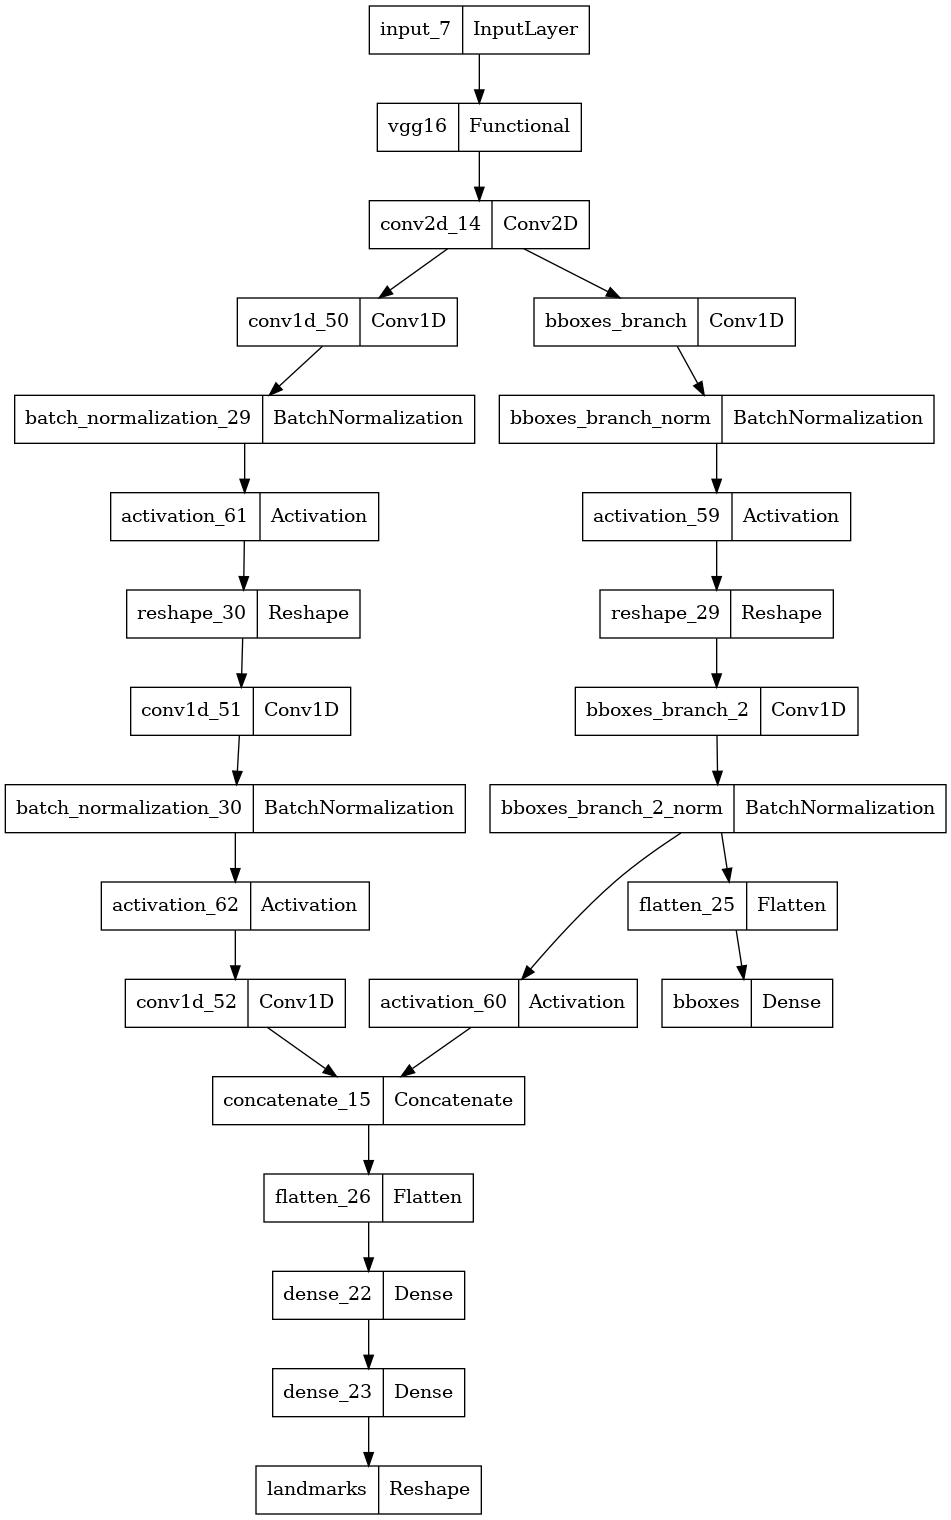

In [211]:
plot_model(model)

### Define loss function

In [93]:
num_labels = None

In [14]:
acc = tf.keras.metrics.CategoricalAccuracy()
cosine_sim = tf.keras.metrics.CosineSimilarity(axis=1)

_max = tf.math.maximum
_min = tf.math.minimum

def compute_iou(y_true, y_pred):
	_shape = K.shape(y_pred)
	total_iou = 0.0

	for i in range(_shape[0]):
		bbox_1 = y_true[i]
		bbox_2 = y_pred[i]
		x_1 = _max(bbox_1[0], bbox_2[0])
		y_1 = _max(bbox_1[1], bbox_2[1])
		x_2 = _min(bbox_1[2], bbox_2[2])
		y_2 = _min(bbox_1[3], bbox_2[3])
		inter_area = _max(0.0, x_2 - x_1 + 1.0) * _max(0.0, y_2 - y_1 + 1.0)

		bbox_1_area = (bbox_1[2] - bbox_1[0] + 1.0) * (bbox_1[3] - bbox_1[1] + 1.0)
		bbox_2_area = (bbox_2[2] - bbox_2[0] + 1.0) * (bbox_2[3] - bbox_2[1] + 1.0)
		total_iou += inter_area / (bbox_1_area + bbox_2_area - inter_area)

	return total_iou / tf.cast(_shape[0], tf.float32)
	
	
@tf.function
def custom_metric(y_true, y_pred):

	# Classification
	if y_pred.shape[1] == num_labels:
		return acc(y_true, y_pred)

	# Landmarks
	if y_pred.shape[1] == 21:
		return cosine_sim(y_true, y_pred)
	
	# Bboxes
	else:
		return compute_iou(y_true, y_pred)


In [13]:
mse = tf.keras.losses.MeanSquaredError()
cross_ent = tf.keras.losses.CategoricalCrossentropy()
huber = tf.keras.losses.Huber()

@tf.function
def custom_loss(y_true, y_pred):
	# Classification
	if y_pred.shape[1] == num_labels:
		return cross_ent(y_true, y_pred) 
	
	# Landmarks
	if y_pred.shape[1] == 21:
		return huber(y_true, y_pred)
	
	# Bboxes
	return mse(y_true, y_pred)

In [51]:
vgg.trainable = True
len(model.trainable_weights)

56

Freeze VGG weights

In [216]:
vgg.trainable = False
len(model.trainable_weights)

26

In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=100,
    run_on_gpu=True,
    loss_function=custom_loss,
    batch_size=None,
    metrics=[custom_metric]
)

save_model(model, "hand_detection_vgg16")

In [97]:
def plot(hist, with_labels=False):	
	f, ax = plt.subplots(2, 3, figsize=(20, 10))	
	ax[0][0].plot(hist.history['loss'], label='Loss')
	ax[0][0].plot(hist.history['val_loss'], label='Validation loss')
	ax[0][0].set_title('Loss', size=20)
	ax[0][0].set_xlabel('Epochs')
	ax[0][0].set_ylabel('Loss')
	ax[0][0].legend()

	# Bboxes
	ax[0][1].plot(hist.history['bboxes_loss'], label='Bboxes loss')
	ax[0][1].plot(hist.history['val_bboxes_loss'], label='Validation Bboxes loss')
	ax[0][1].set_title('Bboxes', size=20)
	ax[0][1].set_xlabel('Epochs')
	ax[0][1].set_ylabel('Loss')
	ax[0][1].legend()
	ax[0][2].plot(hist.history['bboxes_custom_metric'], label='Bboxes IoU')
	ax[0][2].plot(hist.history['val_bboxes_custom_metric'], label='Validation Bboxes IoU')
	ax[0][2].set_title('Bboxes', size=20)
	ax[0][2].set_xlabel('Epochs')
	ax[0][2].set_ylabel('IoU')
	ax[0][2].legend()

	# Landmarks
	if not(with_labels):
		ax[1][0].plot(hist.history['landmarks_loss'], label='Landmarks loss')
		ax[1][0].plot(hist.history['val_landmarks_loss'], label='Validation Landmarks loss')
		ax[1][0].set_title('Landmarks', size=20)
		ax[1][0].set_xlabel('Epochs')
		ax[1][0].set_ylabel('Loss')
		ax[1][0].legend()
		ax[1][1].plot(hist.history['landmarks_custom_metric'], label='Landmarks Cosine Similarity')
		ax[1][1].plot(hist.history['val_landmarks_custom_metric'], label='Validation Landmarks Cosine Similarity')
		ax[1][1].set_title('Landmarks', size=20)
		ax[1][1].set_xlabel('Epochs')
		ax[1][1].set_ylabel('Cosine Similarity')
		ax[1][1].legend()

	# Learning rate
	ax[1][2].plot(hist.history['lr'], label='Learning rate')
	ax[1][2].set_title('Learning rate', size=20)
	ax[1][2].set_xlabel('Epochs')
	ax[1][2].set_ylabel('Learning rate')
	ax[1][2].legend()

	# Classifier
	if with_labels:
		ax[1][0].plot(hist.history['classifier_loss'], label='Classifier loss')
		ax[1][0].plot(hist.history['val_classifier_loss'], label='Validation classifier loss')
		ax[1][0].set_title('Classifier', size=20)
		ax[1][0].set_xlabel('Epochs')
		ax[1][0].set_ylabel('Loss')
		ax[1][0].legend()
		ax[1][1].plot(hist.history['classifier_custom_metric'], label='Classifier Accuracy')
		ax[1][1].plot(hist.history['val_classifier_custom_metric'], label='Validation classifier Accuracy')
		ax[1][1].set_title('Classifier', size=20)
		ax[1][1].set_xlabel('Epochs')
		ax[1][1].set_ylabel('Accuracy')
		ax[1][1].legend()


	plt.tight_layout()
	plt.show()

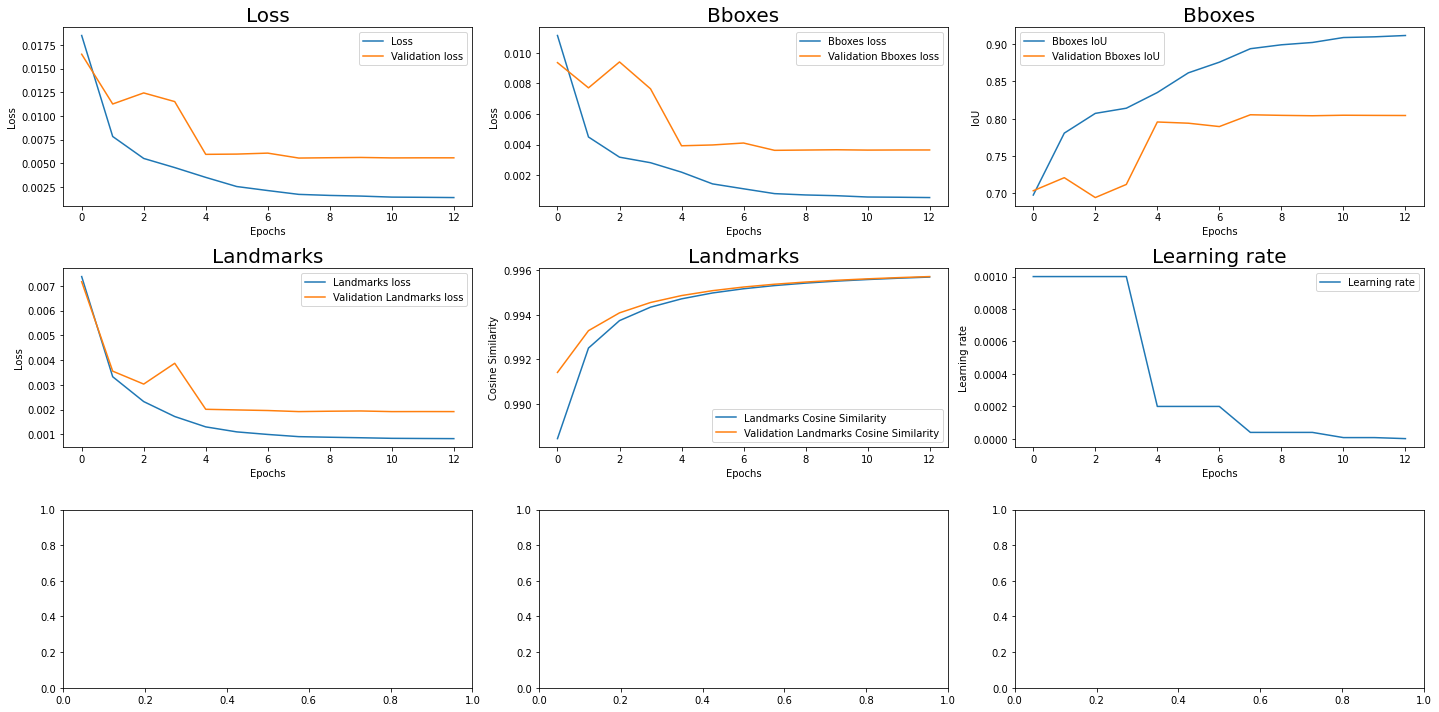

In [219]:
plot(hist)

In [ ]:
model.evaluate(test_gen)

#### Fine tuning

In [220]:
vgg.trainable = True
len(model.trainable_weights)

52

In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=20,
    loss_function=custom_loss,
    metrics=[custom_metric],
    batch_size=None,
    patience=8
)
save_model(model, "hand_detection_vgg16_finetuned")

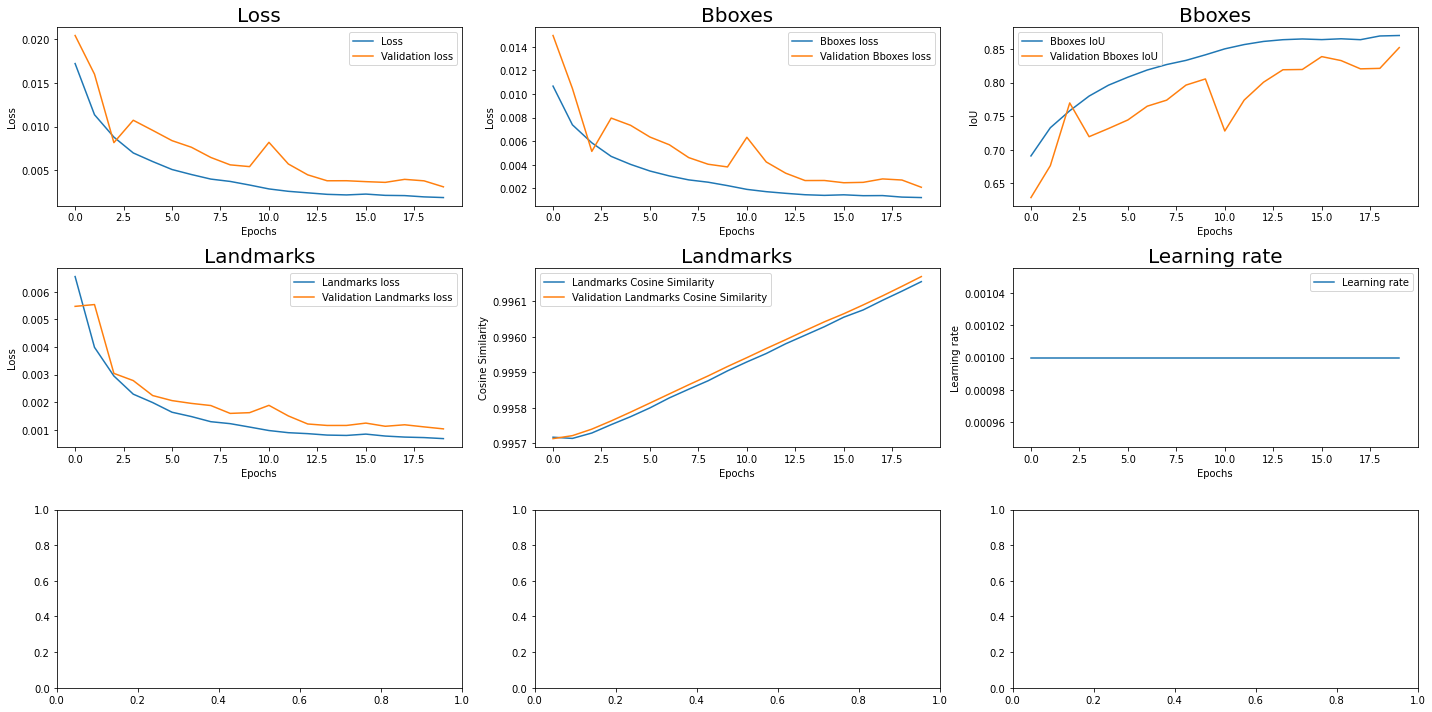

In [222]:
plot(hist)

In [ ]:
model.evaluate(test_gen)

In [ ]:
model.predict(test_gen)

#### Average time to make prediction

In [101]:
def avg_time_pred(model: models.Model, x, max_index: int):
	num_iters = 2000
	count = 0

	for _ in range(num_iters):
		index = randint(0, max_index - 1)

		img = next(iter(x))[0][index]

		start = time.time()

		with tf.device('GPU'):
			model.predict(np.array([img]), verbose=False)

		count += time.time() - start

	print(f"Average time: {round(count / num_iters, 4)} seconds")

In [67]:
avg_time_pred(model, train_gen.as_numpy_iterator(), max_index=BATCH_SIZE)

Average time: 0.0807 seconds


### With classifier

In [15]:
def create_model_classifier(base_model: models.Model, output_dim_bboxes: int, num_classes: int):
	
	#################### Feature extraction ####################

	input_tensor = base_model.input

	x = base_model(input_tensor)

	# (None, 7, 7, 1024)

	x = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(x)

	# (None, 4, 4, 1024)
	
	#################### Boxes ####################


	x_bboxes = layers.Conv1D(256, kernel_size=x.shape[2], strides=1, name="bboxes_branch")(x)
	x_bboxes = layers.BatchNormalization(name="bboxes_branch_norm")(x_bboxes)
	x_bboxes = layers.Activation("relu")(x_bboxes)
	x_bboxes = layers.Reshape(target_shape=(-1, 256))(x_bboxes)

	# (None, 7, 256)
	x_bboxes = layers.Flatten()(x)
	
	x_bboxes = layers.Dense(128)(x_bboxes)
	x_bboxes = layers.BatchNormalization()(x_bboxes)
	x_bboxes = layers.Activation("relu")(x_bboxes)

	x_bboxes = layers.Dense(output_dim_bboxes, activation="sigmoid", name="bboxes")(x_bboxes)

	# Shape (None, 4)
	
	#################### Classification ####################

	x_class = layers.Conv1D(1024, kernel_size=x.shape[2], strides=1)(x)
	x_class = layers.BatchNormalization()(x_class)
	x_class = layers.Activation("relu")(x_class)
	x_class = layers.Reshape(target_shape=(-1, 1024))(x_class)

	# (None, 4, 1024)

	x_class = layers.Conv1D(512, kernel_size=2, strides=1, padding="same")(x)
	x_class = layers.BatchNormalization()(x_class)
	x_class = layers.Activation("relu")(x_class)

	x_class = layers.Flatten()(x_class)
	
	x_class = layers.Dense(256)(x_class)
	x_class = layers.BatchNormalization()(x_class)
	x_class = layers.Activation("relu")(x_class)
	
	x_class = layers.Dense(128)(x_class)
	x_class = layers.BatchNormalization()(x_class)
	x_class = layers.Activation("relu")(x_class)
	
	x_class = layers.Dense(num_classes, activation="softmax", name="classifier")(x_class)

	# (None, 19)

	return models.Model(inputs=[input_tensor], outputs=[x_bboxes, x_class])


In [20]:
BATCH_SIZE = 25
x, y, labels = preprocessing.load_data_hand_detection(DIR_ANNOTATIONS, DIR_IMAGES, with_labels=True)
x, y = shuffle(x, y)
dataset_size = len(x)
num_labels = len(labels)

In [21]:
train_gen = get_dataset(0, train_perc, x, y, BATCH_SIZE, dataset_size, square_img=False, with_labels=True)

test_gen = get_dataset(train_perc, train_perc + test_perc, x, y, BATCH_SIZE, dataset_size, repeat=False, square_img=False, with_labels=True)

val_gen = get_dataset(1 - val_perc, 1, x, y, BATCH_SIZE, dataset_size, square_img=False, with_labels=True)

In [35]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH // 4, IMG_HEIGHT // 4, 3))

In [36]:
vgg.trainable = False

In [37]:
model = create_model_classifier(vgg, output_dim_bboxes=4, num_classes=num_labels)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 480, 270, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 15, 8, 512)   14714688    ['input_4[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 13, 6, 512)   2359808     ['vgg16[0][0]']                  
                                                                                                  
 flatten_6 (Flatten)            (None, 39936)        0           ['conv2d_3[0][0]']         

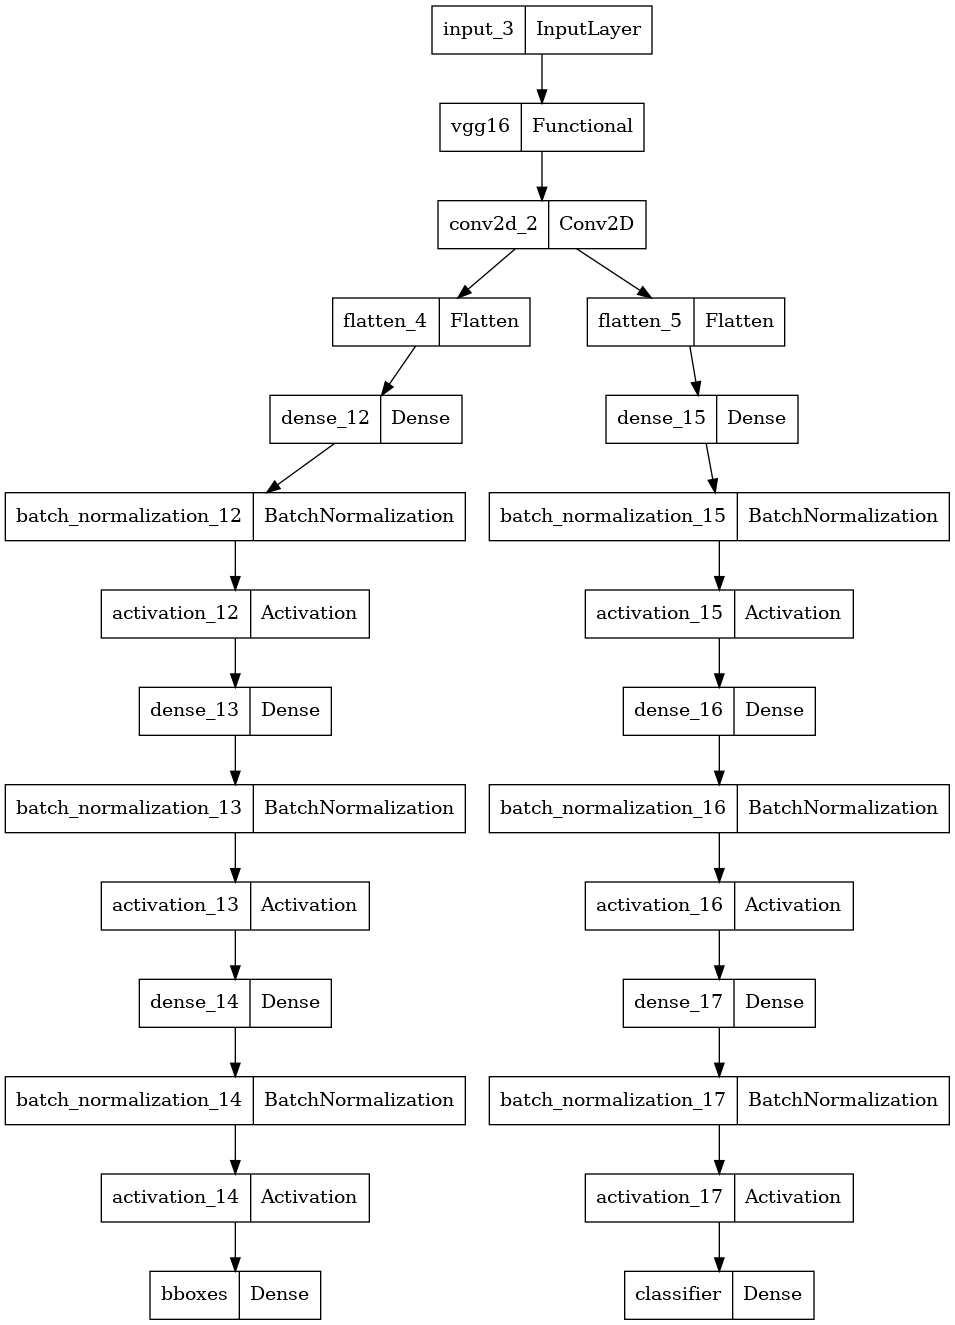

In [29]:
plot_model(model)

In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=100,
    run_on_gpu=True,
    loss_function=custom_loss,
    batch_size=None,
    metrics=[custom_metric]
)

save_model(model, "hand_detection_vgg16_classifier")

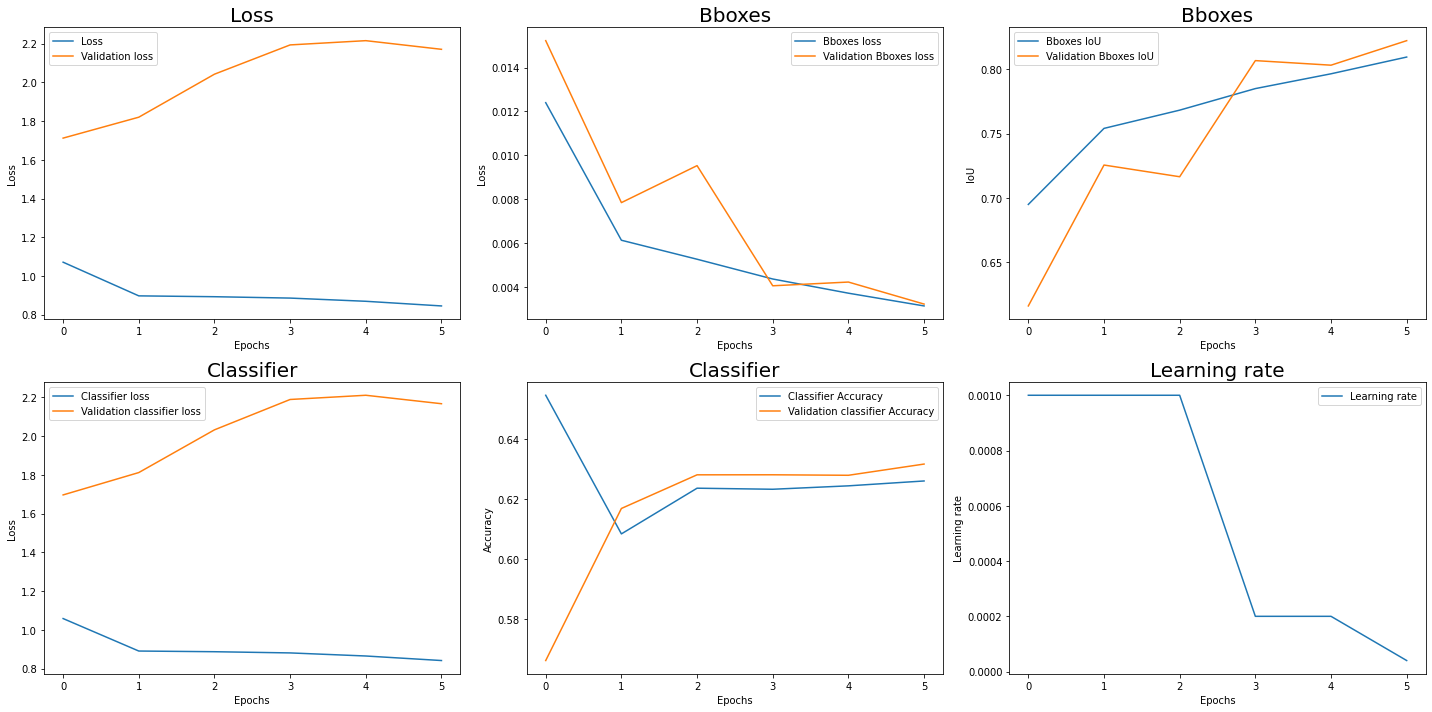

In [39]:
plot(hist, with_labels=True)

In [40]:
vgg.trainable = True
len(model.trainable_weights)

56

In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=100,
    run_on_gpu=True,
    loss_function=custom_loss,
    batch_size=None,
    metrics=[custom_metric]
)

save_model(model, "hand_detection_vgg16_classifier_finetuned")

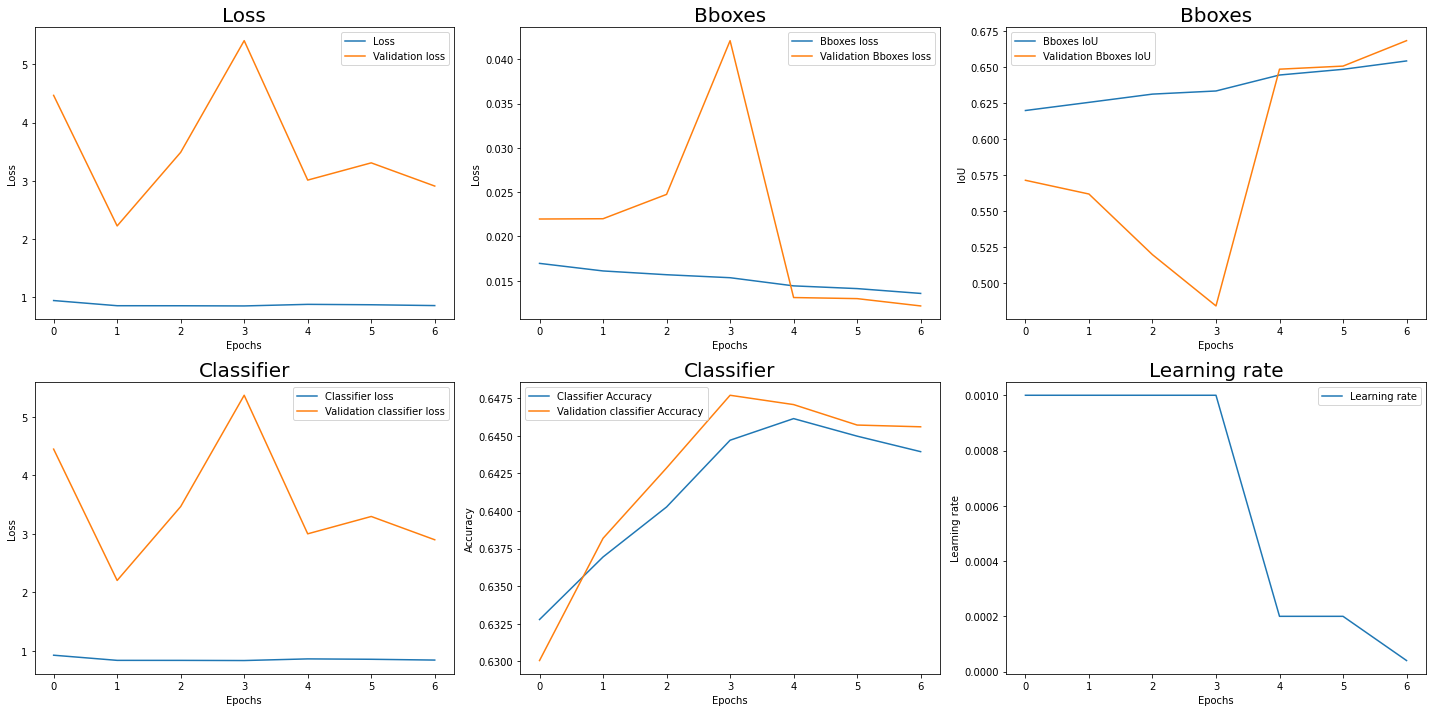

In [42]:
plot(hist, with_labels=True)

### Model 2: From MobileNet

In [83]:
BATCH_SIZE = 32

In [10]:
# Load data without labels
x, y = preprocessing.load_data_hand_detection(DIR_ANNOTATIONS, DIR_IMAGES)
x, y = shuffle(x, y)

Needs some resize

In [84]:
train_gen = get_dataset(0, train_perc, x, y, BATCH_SIZE, dataset_size, square_img=True)

test_gen = get_dataset(train_perc, train_perc + test_perc, x, y, BATCH_SIZE, dataset_size, repeat=False, square_img=True)

val_gen = get_dataset(1 - val_perc, 1, x, y, BATCH_SIZE, dataset_size, square_img=True)

In [85]:
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [47]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [88]:
model = create_model(mobilenet, output_dim_bboxes=4, output_shape_landmarks=(21, 2))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_224 (Functional  (None, 7, 7, 1024)  3228864     ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 5, 5, 512)    4719104     ['mobilenet_1.00_224[0][0]']     
                                                                                              

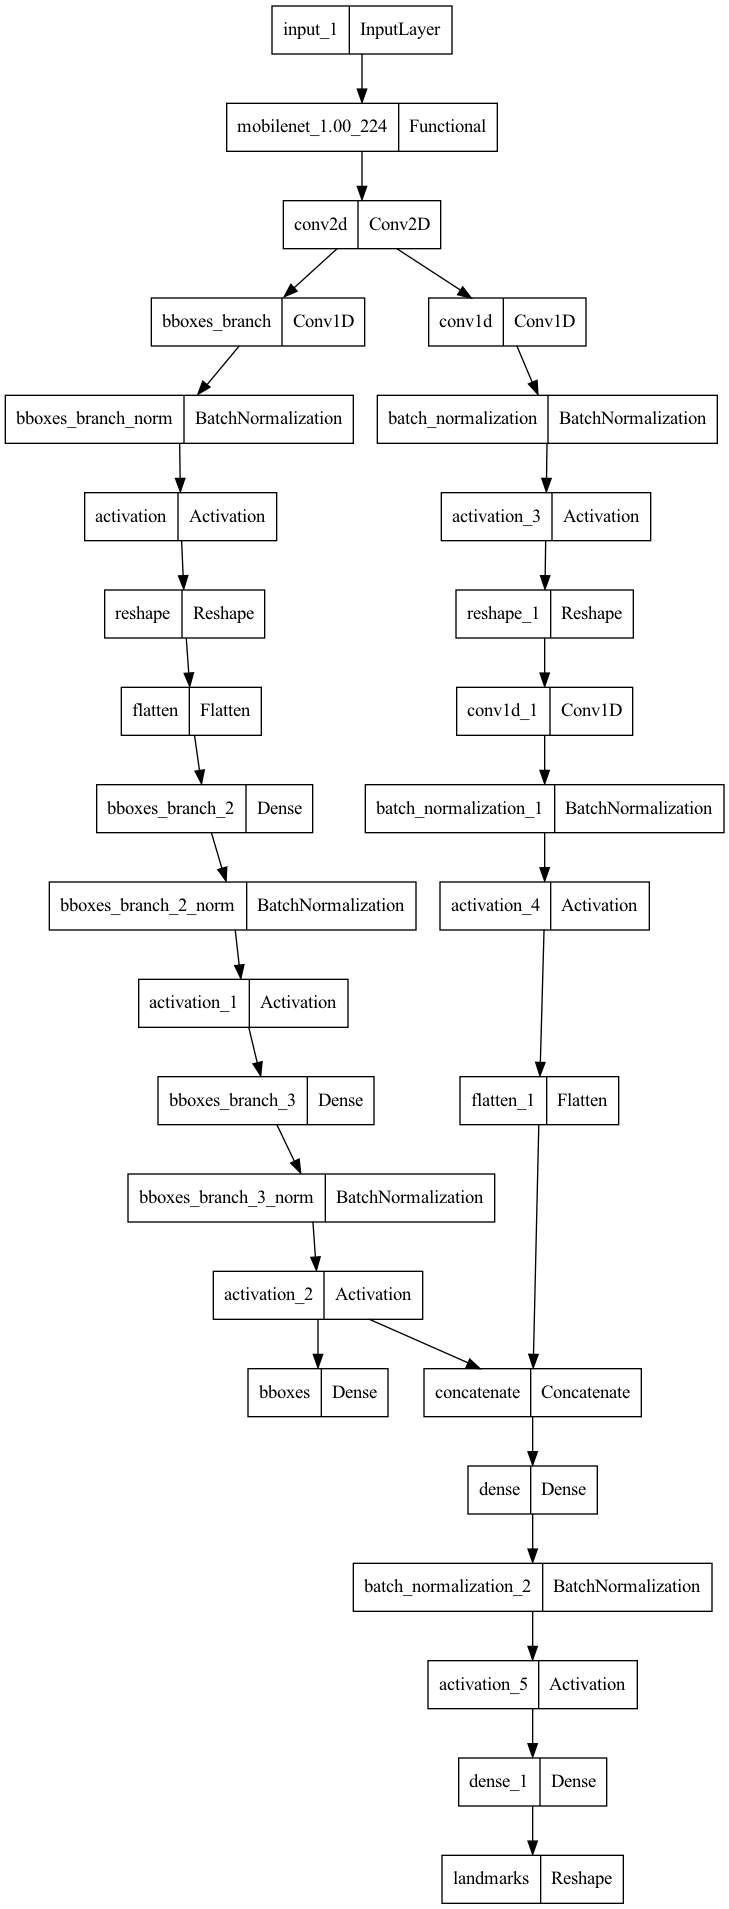

In [89]:
plot_model(model, to_file="mobileNet_model.png")

In [90]:
mobilenet.trainable = True
len(model.trainable_weights)

111

In [91]:
mobilenet.trainable = False
len(model.trainable_weights)

30

In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=100,
    run_on_gpu=True,
    loss_function=custom_loss,
    batch_size=None,
    metrics=[custom_metric]
)

save_model(model, "hand_detection_mobilenet")

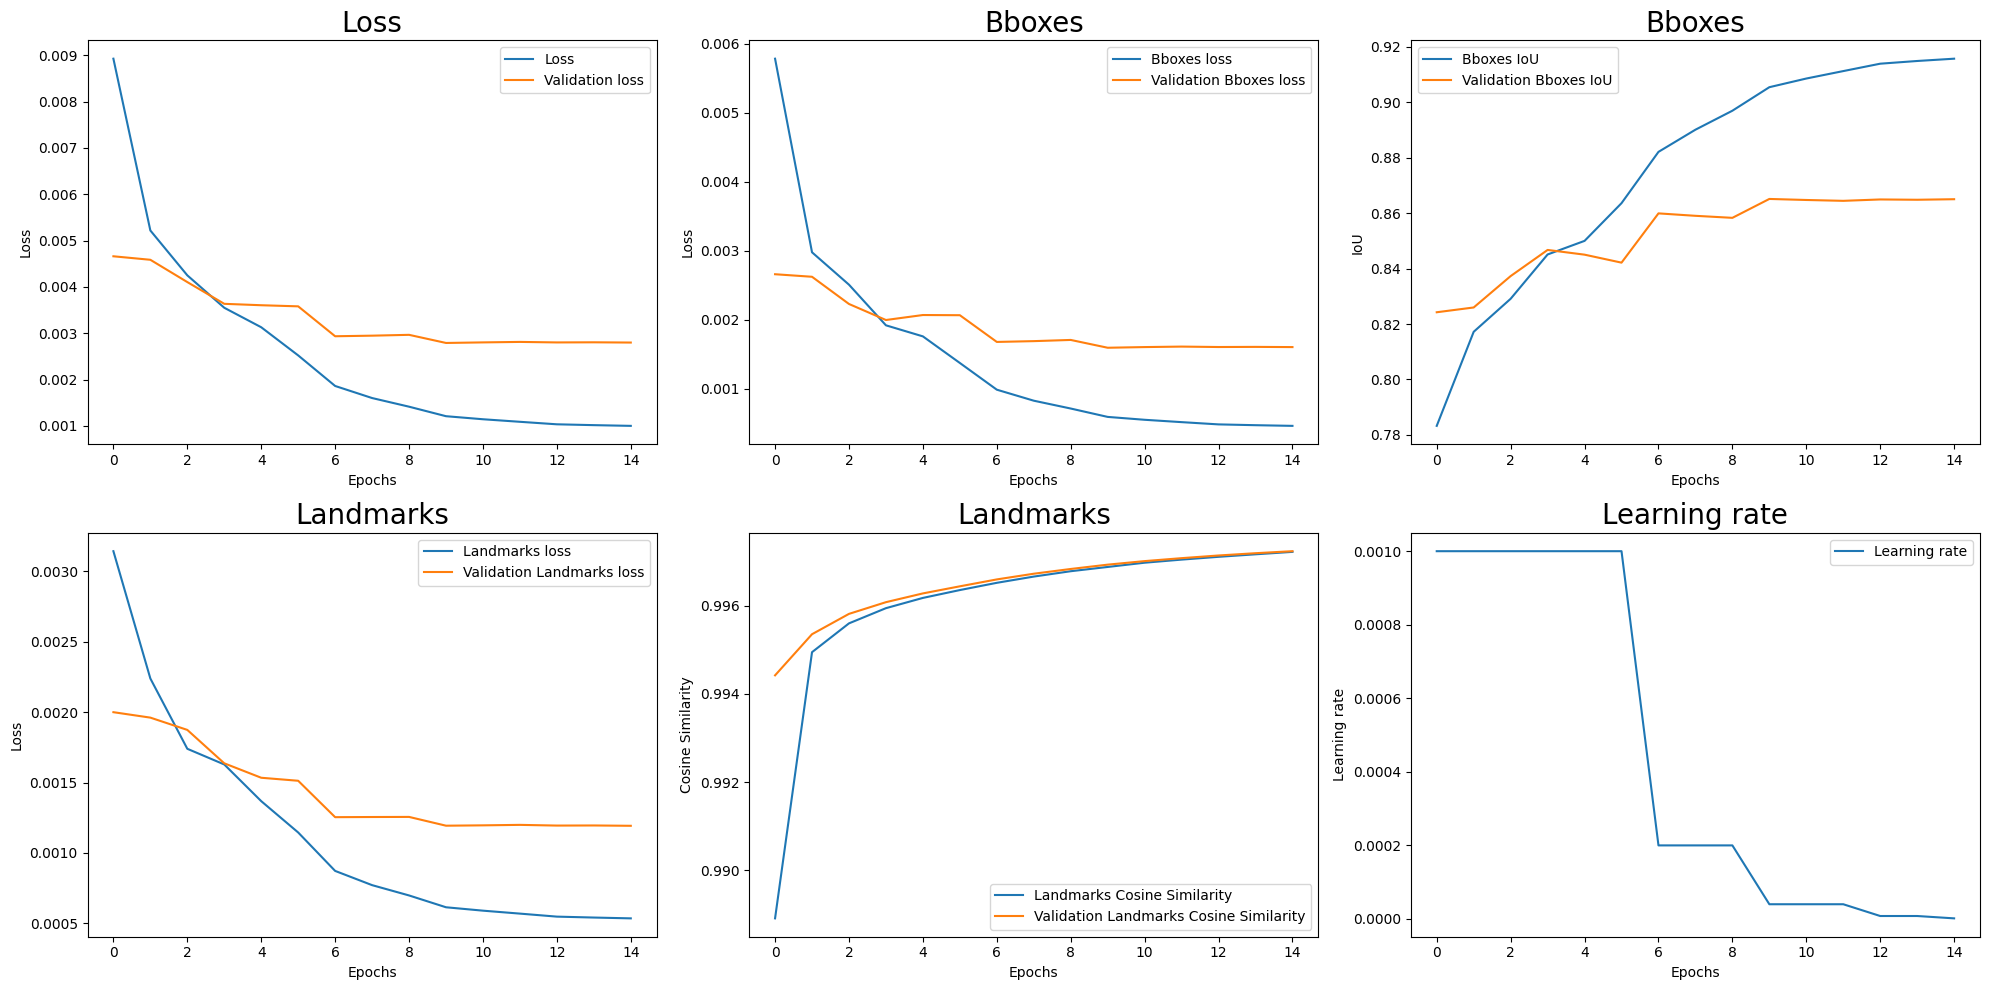

In [98]:
plot(hist)

In [ ]:
model.evaluate(test_gen)

#### Test with classifier (main_conv1d)

In [99]:
# Load classifier
model_classifier = models.load_model(f"{DIR_MODELS}/model_conv1d.h5")

In [ ]:
# Predict landmarks on test data
y_pred_ldm = model.predict(test_gen.as_numpy_iterator())

In [101]:
test_gen = get_dataset(train_perc, train_perc + test_perc, x, y, BATCH_SIZE, dataset_size, repeat=False, square_img=True)

In [ ]:
_y_true = []
for res in test_gen.as_numpy_iterator():
    _y_true.append(res[1])
    
y_true = []
for i in range(len(_y_true)):
    y_true.append(_y_true[i][1])

_y_true = np.array(y_true)
y_true = np.stack([_y_true[i] for i in range(len(y_true) - 1)], axis=0).reshape(-1, 21, 2)

In [103]:
y_pred_class = model_classifier.predict(y_pred_ldm[1][:y_true.shape[0]], verbose=False)
y_pred_class = np.argmax(y_pred_class, axis=1)

In [ ]:
y_labels, labels = preprocessing.load_data_hand_detection(DIR_ANNOTATIONS, DIR_IMAGES, just_labels=True)
y_labels = y_labels[int(train_perc * dataset_size): int((train_perc + test_perc) * dataset_size)][:y_true.shape[0]]
y_labels = np.argmax(y_labels, axis=1)

In [105]:
def print_summary(y_true, y_pred):
	precision = round(100 * precision_score(y_true, y_pred, average="macro"), 3)
	recall = round(100 * recall_score(y_true, y_pred, average="macro"), 3)
	f1_score = round(2 * precision * recall / (precision + recall), 3)
	acc = round(100 * accuracy_score(y_true, y_pred))

	print_color(f"Accuracy: ", Fore.CYAN, end='')
	print(f"{acc}%")

	print_color(f"Precision: ", Fore.CYAN, end='')
	print(f"{precision}%")

	print_color(f"Recall: ", Fore.CYAN, end='')
	print(f"{recall}%")

	print_color(f"F1-Score: ", Fore.CYAN, end='')
	print(f"{f1_score}%")

In [106]:
print_summary(y_labels, y_pred_class)

Accuracy: 4%
Precision: 5.704%
Recall: 1.722%
F1-Score: 2.645%


/Users/kooqix/miniconda3/envs/venv_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Fine tuning

In [56]:
mobilenet.trainable = True
len(model.trainable_weights)

107

In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=20,
    run_on_gpu=True,
    loss_function=custom_loss,
    batch_size=None,
    metrics=[custom_metric],
    patience=8
)
save_model(model, "hand_detection_mobilenet_finetuned")

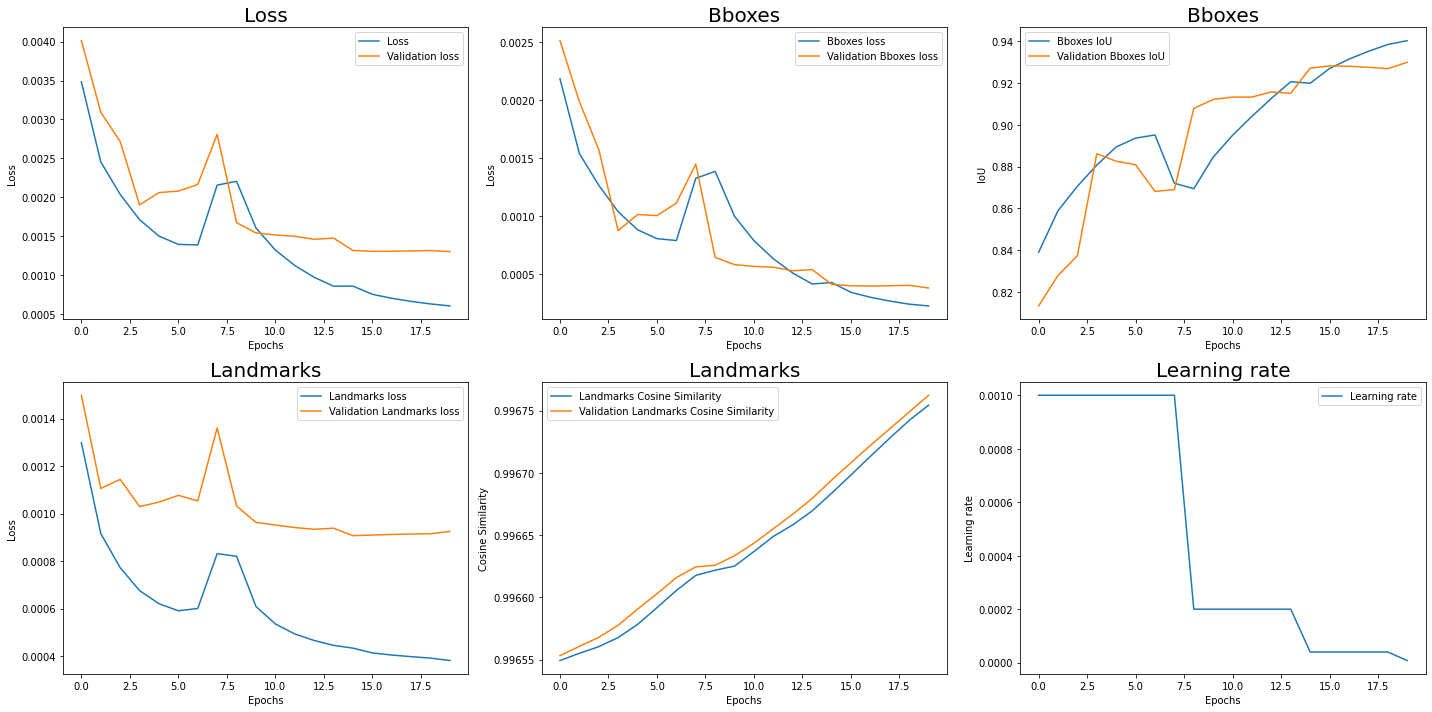

In [58]:
plot(hist)

In [ ]:
model.evaluate(test_gen)

### Average time to make a prediction

In [102]:
avg_time_pred(model, train_gen.as_numpy_iterator(), BATCH_SIZE)

Average time: 0.0374 seconds


### Model 3: From MobileNet with classification

In [16]:
BATCH_SIZE = 25

In [ ]:
x, y, labels = preprocessing.load_data_hand_detection(DIR_ANNOTATIONS, DIR_IMAGES, with_labels=True)
x, y = shuffle(x, y)

In [18]:
dataset_size = len(x)

In [19]:
num_labels = len(labels)
labels

array(['call', 'dislike', 'fist', 'four', 'like', 'mute', 'no_gesture',
       'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop',
       'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted'],
      dtype='<U15')

In [35]:
train_gen = get_dataset(0, train_perc, x, y, BATCH_SIZE, dataset_size, square_img=True, with_labels=True)

test_gen = get_dataset(train_perc, train_perc + test_perc, x, y, BATCH_SIZE, dataset_size, repeat=False, square_img=True, with_labels=True)

val_gen = get_dataset(1 - val_perc, 1, x, y, BATCH_SIZE, dataset_size, square_img=True, with_labels=True)

In [28]:
mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [29]:
model = create_model_classifier(mobilenet, output_dim_bboxes=4, num_classes=num_labels)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_224 (Functional  (None, 7, 7, 1024)  3228864     ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 4, 4, 1024)  0           ['mobilenet_1.00_224[0][0]']     
                                                                                            

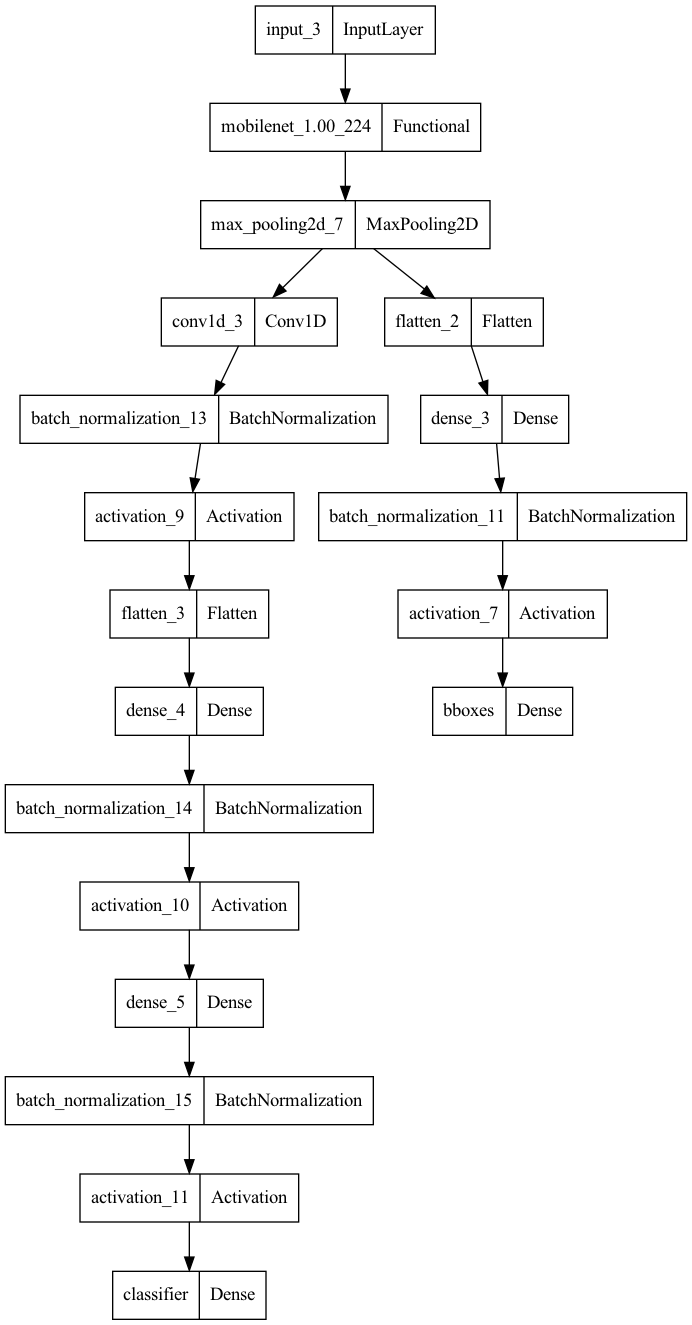

In [30]:
plot_model(model, to_file="mobileNet_model_classifier.png")

Freeze MobileNet weights

In [31]:
print(len(model.trainable_weights))
mobilenet.trainable = False
print(len(model.trainable_weights))

101
20


In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=100,
    run_on_gpu=True,
    loss_function=custom_loss,
    batch_size=None,
    metrics=[custom_metric], 
    patience=10
)

save_model(model, "hand_detection_mobilenet_classifier_2")

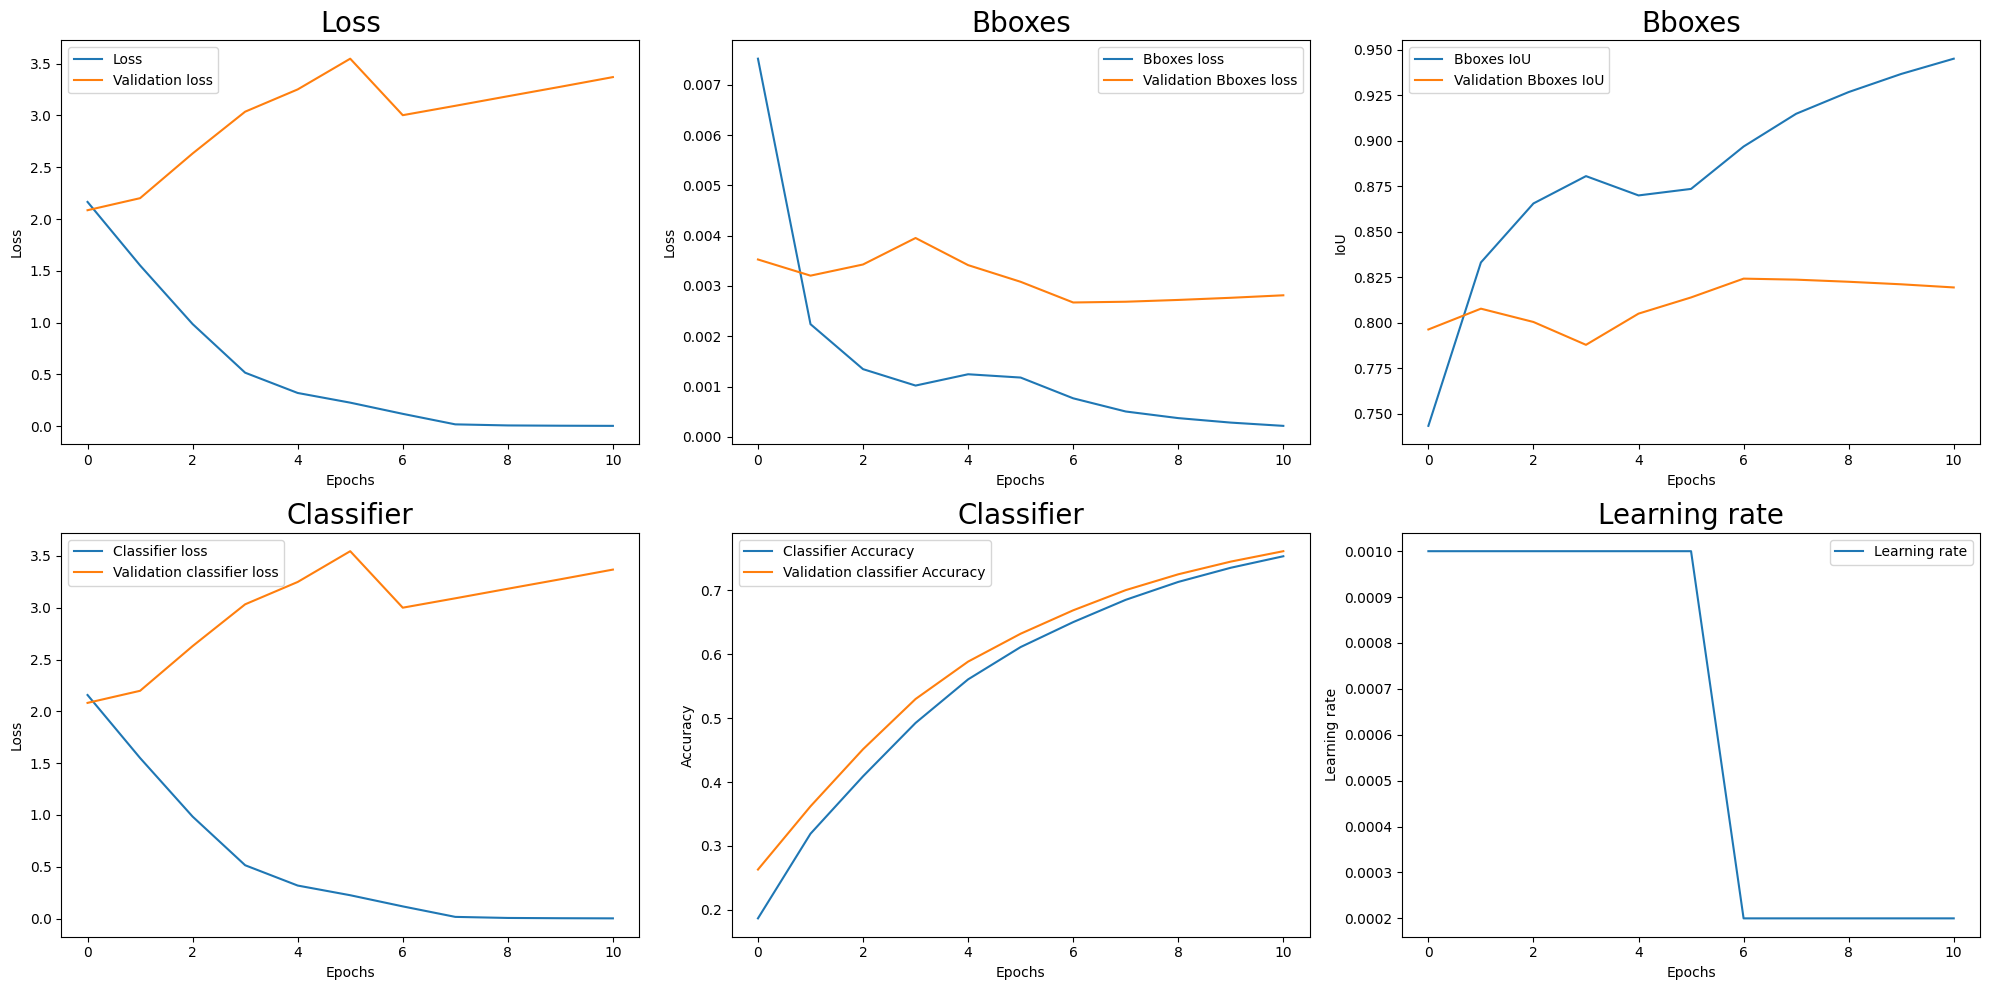

In [34]:
plot(hist, with_labels=True)

In [ ]:
model.evaluate(test_gen, batch_size=BATCH_SIZE)

Fine-tuning

In [35]:
mobilenet.trainable = True

In [36]:
len(model.trainable_weights)

101

In [ ]:
hist = compile_and_fit(
    model,
    x=train_gen.as_numpy_iterator(),
    steps_per_epoch=int(train_perc * dataset_size) // BATCH_SIZE,
    validation_data=val_gen.as_numpy_iterator(),
    validation_steps=int(val_perc * dataset_size) // BATCH_SIZE,
	max_epochs=100,
    run_on_gpu=True,
    loss_function=custom_loss,
    batch_size=None,
    metrics=[custom_metric],
    patience=5
)
save_model(model, "hand_detection_mobilenet_classifier_finetuned")

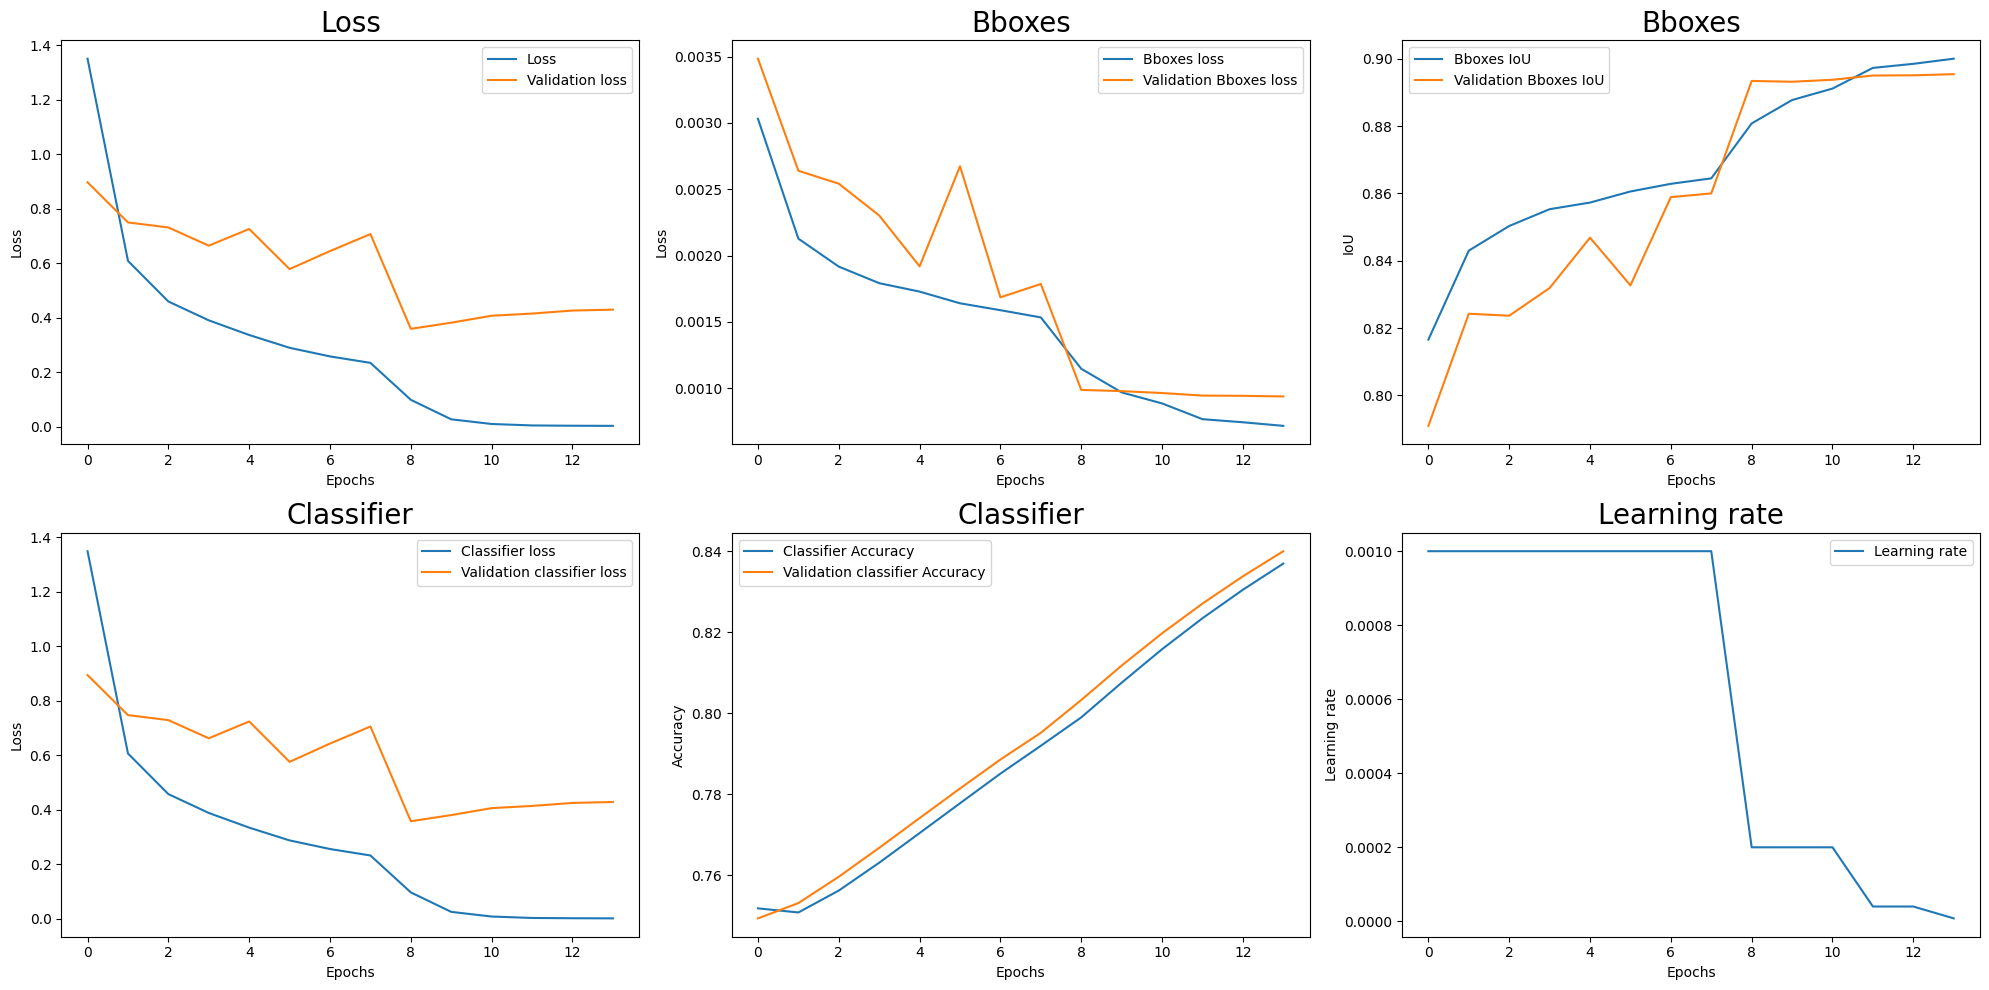

In [38]:
plot(hist, with_labels=True)

In [162]:
y_pred = model.predict(test_gen.as_numpy_iterator(), verbose=False)

In [164]:
test_gen = get_dataset(train_perc, train_perc + test_perc, x, y, BATCH_SIZE, dataset_size, repeat=False, square_img=True, with_labels=True)

In [ ]:
_y_true = []
for res in test_gen.as_numpy_iterator():
    _y_true.append(res[1])
    
y_true = []
for i in range(len(_y_true)):
    y_true.append(_y_true[i][1])

_y_true = np.array(y_true)
y_true = np.stack([_y_true[i] for i in range(len(y_true) - 1)], axis=0).reshape(-1, num_labels)

Reverse One hot encoding to number {0, ..., num_class-1}

In [194]:
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred[1][ :y_true.shape[0]], axis=1)

In [200]:
print_summary(y_true, y_pred)

Accuracy: 86.21%
Precision: 87.368%
Recall: 84.984%
F1-Score: 86.16%


### Display

In [134]:
IMG_PATH = DIR_IMAGES
DATASET_ANNOT_PATH = DIR_ANNOTATIONS
PREFIX = ""
import random as rd
import os
import json
sep='/'
SQUARE_IMG = True
CLASSIFIER = True

In [133]:
model = models.load_model(f"{DIR_MODELS}/hand_detection_mobilenet_classifier_finetuned.h5", {'custom_loss': custom_loss, 'custom_metric': custom_metric})

In [111]:
model_classifier = load_model("model_conv1d")

In [114]:
def draw_landmarks_bbox(img_name: str, label: str="", from_json: bool=False, landmarks: list=[], bboxes: list=[]):
	"""Draw the landmarks and bounding boxes on the image.
	Args:
		img_name (str): The path to the image.
		label (str, optional): The label of the image. Defaults to "". If from_json is True, label must be specified.
		from_json (bool, optional): Whether to get the landmarks and bounding boxes from the label.json file. Defaults to False.
		landmarks (list, optional): The landmarks to draw on the image. Defaults to [].
		bboxes (list, optional): The bounding boxes to draw on the image. Defaults to [].
		Returns:
		None
	"""
	if from_json and label != "":
		# Get the landmarks from the image in the label.json file
		img_stem = img_name.split(sep)[-1].split(".")[0]
		annot_path = f"{DATASET_ANNOT_PATH}/{label}.json"

		with open(annot_path) as f:
			annot = json.load(f)
			
		landmarks = annot[img_stem]['landmarks']
		bboxes = annot[img_stem]['bboxes']
	elif from_json and label == "":
		raise ValueError("If from_json is True, label must be specified.")

	img = cv2.imread(img_name)
	# Reduce the image size to 1/4
	img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
	img_h, img_w, img_c = img.shape
	# Draw the bounding box on the image
	for box in bboxes:
		x, y, w, h = int(box[0]*img_w), int(box[1]*img_h), int(box[2]*img_w), int(box[3]*img_h)
		cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
	# Draw the landmarks and lines between the landmarks on the image
	lm_edges = [(0, 1), (0, 17), (1, 2), (2, 3), (3, 4), (0, 5), (5, 6), (6, 7), (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14), (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)]
	for lm in landmarks:
		for edge in lm_edges:
			x1, y1 = int(lm[edge[0]][0]*img_w), int(lm[edge[0]][1]*img_h)
			x2, y2 = int(lm[edge[1]][0]*img_w), int(lm[edge[1]][1]*img_h)
			cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
		for coord in lm:
			x, y = int(coord[0]*img_w), int(coord[1]*img_h)
			# Adapt the size of the circle according to the box area
			lm_size = int((w*h)**0.5/50)
			cv2.circle(img, (x, y), lm_size, (255, 0, 255), cv2.FILLED)

	plt.imshow(img)


In [81]:
labels

array(['call', 'dislike', 'fist', 'four', 'like', 'mute', 'no_gesture',
       'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop',
       'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted'],
      dtype='<U15')

In [135]:
label = rd.choice(np.delete(labels, 6)) # Except 'no_gesture'
img_list = os.listdir(f"{IMG_PATH}/{PREFIX+label}")
img_name = rd.choice(img_list)

img = img_to_array(load_img(f"{IMG_PATH}/{label}/{img_name}")) / 255.0
		
# resize images to same size each
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

# Downsample for training (my computer can't handle training using Full HD resolution images)
img = cv2.pyrDown(img)
img = cv2.pyrDown(img)

# MobileNet requires square images
if SQUARE_IMG: img = cv2.resize(img, (224, 224))

y_pred = model.predict(np.array([img]), verbose=False)

Prediction

True label: palm || Predicted label: palm


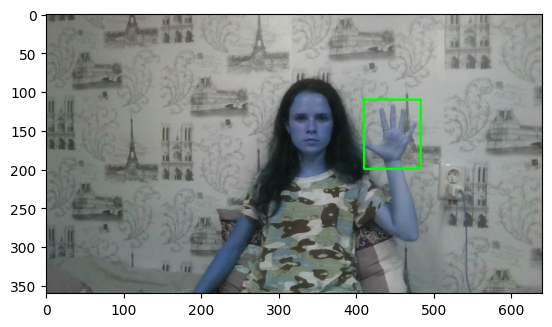

In [136]:
bbox = y_pred[0]
landmarks = y_pred[1] if not(CLASSIFIER) else []

if CLASSIFIER: print(f"True label: {label} || Predicted label: {labels[np.argmax(y_pred[1])]}")
else: 
	res = model_classifier.predict(landmarks, verbose=False)
	print(f"True label: {label} || Predicted from landmarks: {labels[np.argmax(res[0])]}")
draw_landmarks_bbox(f"{IMG_PATH}/{label}/{img_name}", label, landmarks=landmarks, bboxes=bbox)

Ground truth

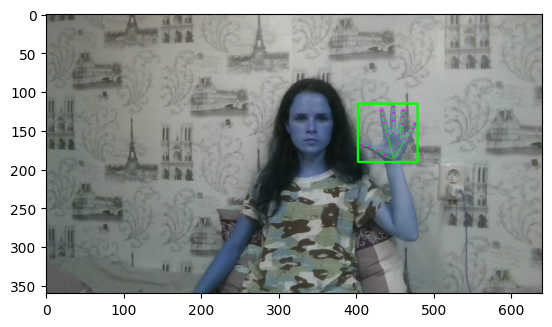

In [137]:
draw_landmarks_bbox(f"{IMG_PATH}/{label}/{img_name}", label, from_json=True)